<a href="https://colab.research.google.com/github/jsansao/dlvc/blob/main/Licao19_IdentificacaoFacial_VisualEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lição 19 - Identificação facial com visual embeddings 

Vamos extrair os visual embeddings usando o VGGFace2 e criar um classificador com SVM. 

## Download do dataset

In [1]:
!wget https://github.com/jsansao/fame-dataset/archive/refs/heads/main.zip

--2021-11-30 23:45:47--  https://github.com/jsansao/fame-dataset/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/jsansao/fame-dataset/zip/refs/heads/main [following]
--2021-11-30 23:45:47--  https://codeload.github.com/jsansao/fame-dataset/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [        <=>         ]  47.24M  20.9MB/s    in 2.3s    

2021-11-30 23:45:49 (20.9 MB/s) - ‘main.zip’ saved [49530242]



In [2]:
!unzip main.zip

Archive:  main.zip
e76125873a9351f49ba1f84baf8e2ff90f3731ab
   creating: fame-dataset-main/
   creating: fame-dataset-main/train/
   creating: fame-dataset-main/train/AlPacino/
  inflating: fame-dataset-main/train/AlPacino/1.al_pacino.jpg  
  inflating: fame-dataset-main/train/AlPacino/11.29373_0d16849303cb824.jpg  
  inflating: fame-dataset-main/train/AlPacino/12.210px-al_pacino_roma_film_fest_cropped.jpg  
  inflating: fame-dataset-main/train/AlPacino/13.image-w856.jpg  
  inflating: fame-dataset-main/train/AlPacino/14.os-80-anos-de-al-pacino0298839100202004251215.jpg  
  inflating: fame-dataset-main/train/AlPacino/15.filmes-com-al-pacino-pdb-117%e2%80%8b.jpg  
  inflating: fame-dataset-main/train/AlPacino/19.al-pacino.jpg  
  inflating: fame-dataset-main/train/AlPacino/2.1337912.jpg  
  inflating: fame-dataset-main/train/AlPacino/23.al_pacino_2016_%2830401544240%29.jpg  
  inflating: fame-dataset-main/train/AlPacino/25.al_pacino.jpg  
 extracting: fame-dataset-main/train/AlPacino/26

## Extração das faces do dataset, geração dos conjuntos de treinamento e validação




In [3]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.9 MB/s 


In [6]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
import mtcnn

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = mtcnn.MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path, (224,224))
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)



In [7]:
# load train dataset
trainX, trainy = load_dataset('/content/fame-dataset-main/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/fame-dataset-main/val/')
# save arrays to one file in compressed format
savez_compressed('fame-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 15 examples for class: EmilyBlunt
>loaded 15 examples for class: ClintEastwood
>loaded 15 examples for class: TomHanks
>loaded 15 examples for class: AlPacino
>loaded 15 examples for class: KristenStewart
>loaded 15 examples for class: MerylStreep
>loaded 20 examples for class: NicolasCage
>loaded 15 examples for class: AngelinaJolie
(125, 224, 224, 3) (125,)
>loaded 3 examples for class: EmilyBlunt
>loaded 11 examples for class: ClintEastwood
>loaded 4 examples for class: TomHanks
>loaded 2 examples for class: AlPacino
>loaded 11 examples for class: KristenStewart
>loaded 11 examples for class: MerylStreep
>loaded 9 examples for class: NicolasCage
>loaded 3 examples for class: AngelinaJolie


## Instação do VGGFACE

In [8]:


!pip install git+https://github.com/jsansao/keras-vggface.git
!pip install keras_applications



  Cloning https://github.com/jsansao/keras-vggface.git to /tmp/pip-req-build-97goyo0i
  Running command git clone -q https://github.com/jsansao/keras-vggface.git /tmp/pip-req-build-97goyo0i
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8315 sha256=1aa9c169f8e1049899dd6bde0df29ac43304c7c33042df65c6db1797a9c7df9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-46kgvahd/wheels/17/1d/de/3357313e72504b373dcd31226714c9477da009000aeb307586
Successfully built keras-vggface
     |████████████████████████████████| 50 kB 3.0 MB/s 


In [9]:


from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray

import mtcnn
from keras.utils.layer_utils import get_source_inputs

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions



## Carregamento do modelo pré-treinado, sem camadas de saída

In [10]:
model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

94707712/94694792 [==============================] - 1s 0us/step


## Extração dos embeddings 

In [11]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
  samples = face_pixels.astype('float32')
  samples = expand_dims(samples, axis=0)
  samples = preprocess_input(samples, version=2)
  # transform face into one sample
  # make prediction to get embedding
  yhat = model.predict(samples)
  return yhat[0]

In [12]:
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

(125, 2048)
(54, 2048)


In [13]:
savez_compressed('fame-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

## Classificação dos embeddings com SVM 

In [14]:

# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('fame-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=125, test=54
Accuracy: train=100.000, test=100.000


## Teste do classificador SVM

In [24]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 26.ixmfr2xxkw5a54glahf5x5umiy.jpg to 26.ixmfr2xxkw5a54glahf5x5umiy.jpg
User uploaded file "26.ixmfr2xxkw5a54glahf5x5umiy.jpg" with length 16912 bytes


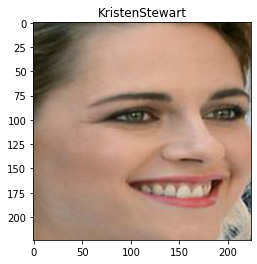

In [25]:
for fn in uploaded.keys():
  face_t = extract_face(fn)
  model_t = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
  embedded_t = get_embedding(model_t, face_t)
  embe_in = embedded_t.reshape(-1,2048)
  yhat_test = model.predict(embe_in)
  saida = out_encoder.inverse_transform(yhat_test)
  pyplot.imshow(face_t)
  pyplot.title(saida[0])
  pyplot.show()
  